# Kwantowa detekcja anomalii z użyciem kwantowego svm oraz klasycznych modeli
Celem prezentacji jest pokazanie, jak można wykorzystać podejście kwantowe czyli QSVM do detekcji anomalii na danych niezbalansowanych oraz porównać je z klasycznymi metodami uczenia maszynowego. Detekcja anomalii polega na identyfikacji obserwacji nietypowych względem większości danych np. wykrywaniu fałszywych transakcji, które są rzadkie, a więc problem jest zwykle mocno niezbalansowany.

Głównymi wyzwaniami w tym projekcie są:
 - Silne niezbalansowany klas, anomalii jest bardzo mało, więc model może mieć wysoką accuracy mimo że prawie nic nie wykrywa
 - Dobór właściwych metryk oceny, kluczowymi są: precision, recall, F1 oraz AUC-ROC
 - Różne założenia modeli, OneClassSVM uczy się tylko na jednaj prawdziwej klasie, a QSVM/SVC jest nadzorowany i korzysta z obu klas, trzeba uważać aby porównanie było fair

### OneClassSVM
`OneClassSVM` to wariant SVM do detekcji anomalii, który uczy się wyłącznie na przykładach normalnych (jedna klasa). Model znajduje w przestrzeni cech (zdefiniowanej przez kernel, np. RBF) granicę opisującą obszar, w którym znajdują się typowe obserwacje. Próbki leżące poza tą granicą są oznaczane jako anomalie. Parametr `nu`, kontroluje kompromis między „ścisłością” granicy a dopuszczalnym odsetkiem punktów uznanych za odstające.

### Quantum SVM
`QSVM` w praktyce oznacza zwykle SVM, w którym zamiast klasycznego kernela stosuje się kwantowy kernel. Dane wejściowe są kodowane do stanu kwantowego za pomocą feature map (obwodu kwantowego), a podobieństwo między próbkami jest liczone jako fidelity (miara bliskości stanów kwantowych). Otrzymujemy macierz kernela, którą następnie można użyć w klasycznym algorytmie SVM. W wariancie kwantowym używam one-class SVM z kwantowym kernelem, więc trening odbywa się tylko na klasie normalnej.

In [1]:
import pandas as pd
import numpy as np
import math
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import zz_feature_map
from qiskit_machine_learning.kernels import FidelityQuantumKernel

### ZZFeatureMap
Jest to kwantowa mapa cech, czyli obwód kwantowy, który koduje klasyczne dane wejściowe (wektor cech) do stanu kwantowego. W praktyce każda cecha steruje parametrami bramek (rotacji) w obwodzie, a dodatkowe sprzężenia między kubitami wprowadzają korelacje między cechami. Dzięki temu dane są „przenoszone” do przestrzeni stanów kwantowych, gdzie podobieństwo między próbkami może mieć inną (bardziej złożoną) strukturę niż w klasycznych kernelach.

### FidelityQuantumKernel
Odpowiada za budowanie kernela: dla dwóch próbek (x) i (y) najpierw przygotowuje stany $$|\phi(x)\rangle$$ i $$|\phi(y)\rangle$$ za pomocą feature map, a następnie liczy ich fidelity (w uproszczeniu: „jak bardzo te stany są do siebie podobne”). Wartości te tworzą macierz kernela, którą można potem wykorzystać np. w SVM.

ZZFeatureMap:


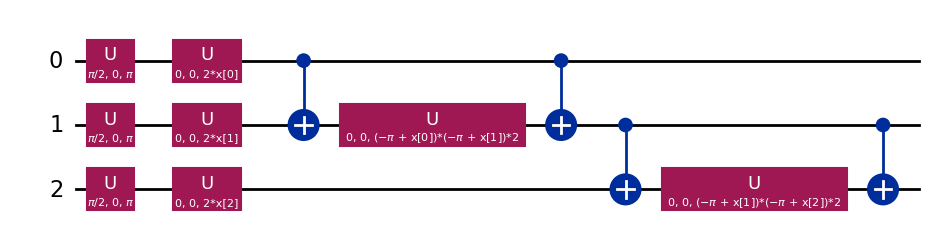


ZZFeatureMap po podstawieniu x1:


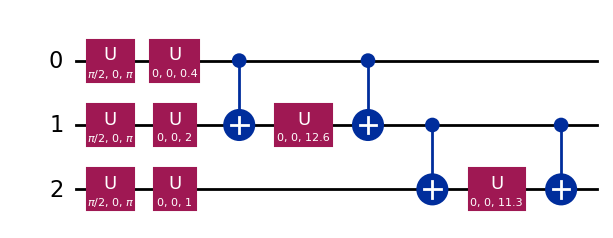


k(x1, x1) = 1.000000
k(x1, x2) = 0.313159

Macierz kernela K (3x3):
[[1.       0.026606 0.751225]
 [0.026606 1.       0.011067]
 [0.751225 0.011067 1.      ]]


In [2]:
n_qubits = 3
feature_map = zz_feature_map(feature_dimension=n_qubits, reps=1, entanglement="linear")

print("ZZFeatureMap:")
display(feature_map.decompose().decompose().draw("mpl", fold=-1))

x1 = np.array([0.2, 1.0, 0.5])
x2 = np.array([0.25, 0.9, 1.0])

bound = feature_map.assign_parameters({p: v for p, v in zip(feature_map.parameters, x1)})
print("\nZZFeatureMap po podstawieniu x1:")
display(bound.decompose().decompose().draw("mpl", fold=-1))

qkernel = FidelityQuantumKernel(feature_map=feature_map)

k_x1_x2 = qkernel.evaluate(x_vec=[x1], y_vec=[x2])[0, 0]
k_x1_x1 = qkernel.evaluate(x_vec=[x1], y_vec=[x1])[0, 0]

print(f"\nk(x1, x1) = {k_x1_x1:.6f}")
print(f"k(x1, x2) = {k_x1_x2:.6f}")

X = np.array([
    [0.2, 1.0, 0.2],
    [2.0, 0.1, 0.4],
    [0.25, 0.9, 0.5],
])
K = qkernel.evaluate(x_vec=X)

print("\nMacierz kernela K (3x3):")
print(np.round(K, 6))

### Przygotowanie danych

W tej części przygotowujemy dane do uczenia i testowania modeli w porównywalny sposób.

- **`make_sub_dataset`** tworzy mniejszy, kontrolowany podzbiór danych z zadanym stosunkiem klas: wybiera losowo określoną liczbę próbek normalnych (Class=0) oraz anomalii (Class=1), a następnie miesza je. Dzięki temu można łatwo wykonywać eksperymenty na różnych rozmiarach zbioru i różnych poziomach niezbalansowania.

- **`prepare_data`** wykonuje kompletny preprocessing:
  1. Dzieli dane na zbiór treningowy i testowy (`train_test_split`) z zachowaniem proporcji klas (`stratify=y`).
  2. Dla modeli `OneClassSVM`, `IsolationForest` i `QSVM` uczy się wyłącznie na danych normalnych z treningu.
  3. Skaluje cechy `MinMaxScaler` oraz redukuje wymiar metodą `PCA` (zmniejsza liczbę cech i ułatwia uczenie).
  4. Dla QSVM dodatkowo skaluje dane do zakresu **[0, π]**, ponieważ cechy danych są używane jako kąty bramek obrotu i mogło by dojść, że dla dwóch różnych wartości byśmy mieli bardzo podobny stan kwantowy.

In [3]:
def make_sub_dataset(df, n_norm=200, n_anom=50, random_state=0):
    df0 = df[df["Class"] == 0]
    df1 = df[df["Class"] == 1]
    
    n_norm = min(n_norm, len(df0))
    n_anom = min(n_anom, len(df1))
    df1s = df1.sample(n=n_anom, random_state=random_state)
    df0s = df0.sample(n=n_norm, random_state=random_state)

    out = pd.concat([df0s, df1s], axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return out

def prepare_data(
    data: pd.DataFrame, test_size=0.3, pca_components=20, quantum=False, random_state=0):
    X = data.drop(columns=["Class"])
    y = data["Class"]

    X_train_df, X_test_df, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    mask_norm = (y_train == 0)
    X_train_used = X_train_df.loc[mask_norm]
    y_train_used = y_train.loc[mask_norm]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_used)
    X_test_scaled = scaler.transform(X_test_df)

    pca = PCA(n_components=pca_components, random_state=random_state)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    fm_scaler = None
    if quantum:
        fm_scaler = MinMaxScaler(feature_range=(0, np.pi))
        X_train_final = fm_scaler.fit_transform(X_train_pca)
        X_test_final = fm_scaler.transform(X_test_pca)
    else:
        X_train_final = X_train_pca
        X_test_final = X_test_pca

    return X_train_final, y_train_used, X_test_final, y_test, scaler, pca, fm_scaler

### Trenowanie modeli i predykcja

Poniższe funkcje trenują wybrane modele detekcji anomalii i zwracają dwa wyniki:  
- `y_pred` - etykiety predykcji (0 = normalne, 1 = anomalia).
- `score` - ciągły wynik anomalii (im większy, tym bardziej podejrzana próbka), używany do AUC-ROC i analizy progów.

Zaimplementowane są trzy podejścia:
- `fit_predict_classical`: OneClassSVM uczony tylko na danych normalnych (podejście one-class).
- `fit_predict_isolation_forest`: IsolationForest jako alternatywna klasyczna metoda nienadzorowana; parametr `contamination` ustawia oczekiwany udział anomalii.
- `fit_predict_qsvm`: nadzorowany SVM z kwantowym kernelem `FidelityQuantumKernel` opartym o `ZZFeatureMap`. Najpierw liczona jest macierz kernela dla treningu i testu, a następnie uczony jest klasyczny `SVC` z `kernel="precomputed"`.

Dodatkowo:
- `compute_metrics` liczy metryki jakości (precision, recall, F1, AUC-ROC i macierz pomyłek).
- `plot_metrics_array` pozwala porównać wyniki w wielu eksperymentach.

In [4]:
def fit_predict_classical(X_train, X_test, nu=0.01):
    clf_svm = OneClassSVM(kernel="rbf", degree=3, gamma="scale", nu=nu)
    clf_svm.fit(X_train)

    y_predict = clf_svm.predict(X_test)
    y_pred = pd.Series(y_predict).replace({1: 0, -1: 1}).to_numpy()

    score = -clf_svm.decision_function(X_test)
    return y_pred, score


def fit_predict_isolation_forest(X_train, X_test, contamination=0.01, n_estimators=300, max_samples="auto", random_state=0):
    iso = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        max_samples=max_samples,
        random_state=random_state,
        n_jobs=-1,
    )
    iso.fit(X_train)

    y_raw = iso.predict(X_test)
    y_pred = pd.Series(y_raw).replace({1: 0, -1: 1}).to_numpy()

    score = -iso.decision_function(X_test)
    return y_pred, score


def fit_predict_qsvm(X_train, X_test, n_qubits=5, reps=2, entanglement="full", nu=0.02):
    feature_map = zz_feature_map(feature_dimension=n_qubits, reps=reps, entanglement=entanglement)
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

    K_train = quantum_kernel.evaluate(x_vec=X_train)
    oc = OneClassSVM(kernel="precomputed", nu=nu)
    oc.fit(K_train)

    K_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

    y_raw = oc.predict(K_test)
    y_pred = pd.Series(y_raw).replace({1: 0, -1: 1}).to_numpy()

    score = -oc.decision_function(K_test)
    return y_pred, score


def compute_metrics(y_true, y_pred, score=None):
    out = {
        "precision": float(precision_score(y_true, y_pred, pos_label=1, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, pos_label=1, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, pos_label=1, zero_division=0)),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist(),
    }
    if score is not None:
        out["auc-roc"] = float(roc_auc_score(y_true, score))
    return out


def plot_metrics_array(metrics_list, metrics=None, metric=None, title="Wyniki compute_metrics"):
    if not metrics_list:
        raise ValueError("metrics_list jest puste")

    if metric is not None:
        metrics = [metric]
    elif metrics is None:
        metrics = [k for k, v in metrics_list[0].items() if isinstance(v, (int, float))]

    x = list(range(1, len(metrics_list) + 1))

    numeric_metrics = [m for m in metrics if m != "confusion_matrix"]

    if numeric_metrics:
        plt.figure(figsize=(10, 4))

        if len(numeric_metrics) == 1:
            m = numeric_metrics[0]
            y = [d.get(m, float("nan")) for d in metrics_list]
            plt.bar(x, y)
            plt.ylabel(m)
            plt.xticks(x)
        else:
            for m in numeric_metrics:
                y = [d.get(m, float("nan")) for d in metrics_list]
                plt.plot(x, y, marker="o", label=m)
            plt.legend()
            plt.xticks(x)
            plt.ylabel("wartość")

        plt.title(title)
        plt.xlabel("iteracja / eksperyment")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    if "confusion_matrix" in metrics:
        cms = []
        labels = []
        for i, d in enumerate(metrics_list, start=1):
            cm = d.get("confusion_matrix")
            if cm is None:
                continue
            cms.append(np.asarray(cm))
            labels.append(f"#{i}")

        if cms:
            n = len(cms)
            cols = min(3, n)
            rows = math.ceil(n / cols)
            fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.0, rows * 3.0), constrained_layout=True)
            axes = np.atleast_2d(axes)

            for idx in range(rows * cols):
                r, c = divmod(idx, cols)
                ax = axes[r, c]
                if idx < n:
                    disp = ConfusionMatrixDisplay(confusion_matrix=cms[idx], display_labels=(0, 1))
                    disp.plot(ax=ax, colorbar=False, values_format="d")
                    ax.set_title(f"{title} {labels[idx]}", fontsize=10)
                else:
                    ax.axis("off")

            plt.show()

### Eksperymenty i porównanie modeli

- Wczytujemy zbiór `creditcard.csv`, a następnie tworzymy mniejsze podzbiory.
- Dla każdego wariantu danych wykonujemy preprocessing, trenujemy model i zapisujemy metryki.
- Porównujemy trzy podejścia:
  - **OneClassSVM** oraz **IsolationForest** – klasyczne modele uczone tylko na danych normalnych,
  - **QSVM (SVC z kwantowym kernelem)** – kwantowy kernel wykorzystany w OneClassSVM uczony na danych normalnych.
- Na końcu wizualizujemy wyniki (precision, recall, F1, AUC-ROC i macierze pomyłek) dla każdego eksperymentu, co pozwala ocenić, jak zmiana liczby próbek i niezbalansowania wpływa na skuteczność detekcji anomalii.
  - precision - jaki odsetek wykrytych przez model anomalii faktycznie jest anomalią,
  - recall - jaki odsetek wszystkich prawdziwych anomalii model wykrył,
  - F1 - średnia harmoniczna precision i recall
  - AUC-ROC - jak dobrze model rozróżnia klasy dla wszystkich możliwych progów decyzji. Pole pod krzywą ROC, która pokazuje kompromis między: **TPR** (True Positive Rate) = recall, **FPR** (False Positive Rate) = $$\frac{FP}{FP+TN}$$

In [ ]:
df = pd.read_csv("./creditcard.csv")

classical_runs_1 = []
classical_runs_2 = []
quantum_runs_1 = []
isolation_runs = []
quantum_runs_2 = []

data_size_classical_1 = [(1000, 10), (10000, 100), (100000, 1000)]
data_size_classical_2 = [(200, 20), (400, 40), (800, 80)]
data_size_quantum_1 = [(200, 20), (400, 40), (800, 80)]
data_size_quantum_2 = [(200, 4), (400, 8), (800, 16)]

for (n_norm, n_anom) in data_size_classical_1:
    data = make_sub_dataset(df, n_norm, n_anom)

    X_train, y_train, X_test, y_test, scaler, pca, _ = prepare_data(data=data, test_size=0.3, pca_components=29, quantum=False)
    pred, score = fit_predict_classical(X_train, X_test)
    classical_runs_1.append(compute_metrics(y_test, pred, score))

for (n_norm, n_anom) in data_size_classical_2:
    data = make_sub_dataset(df, n_norm, n_anom)

    X_train, y_train, X_test, y_test, scaler, pca, _ = prepare_data(data=data, test_size=0.3, pca_components=6, quantum=False)
    pred, score = fit_predict_classical(X_train, X_test, nu=0.1)
    classical_runs_2.append(compute_metrics(y_test, pred, score))

for (n_norm, n_anom) in data_size_quantum_1:
    data = make_sub_dataset(df, n_norm, n_anom)

    X_train, y_train, X_test, y_test, scaler, pca, fm_scaler = prepare_data(
        data=data, test_size=0.3, pca_components=5, quantum=True
    )

    pred, score = fit_predict_qsvm(X_train, X_test, n_qubits=5, reps=2, entanglement="linear", nu=0.1)
    quantum_runs_1.append(compute_metrics(y_test, pred, score))

for (n_norm, n_anom) in data_size_quantum_2:
    data = make_sub_dataset(df, n_norm, n_anom)

    X_train, y_train, X_test, y_test, scaler, pca, fm_scaler = prepare_data(data=data, test_size=0.3, pca_components=2, quantum=True)
    pred, score = fit_predict_qsvm(X_train, X_test, n_qubits=2, reps=2, entanglement="linear")
    quantum_runs_2.append(compute_metrics(y_test, pred, score))

for (n_norm, n_anom) in data_size_classical_1:
    data = make_sub_dataset(df, n_norm, n_anom)

    X_train, y_train, X_test, y_test, scaler, pca, _ = prepare_data(
        data=data, test_size=0.3, pca_components=20, quantum=False
    )

    contamination = n_anom / (n_norm + n_anom)

    pred_iso, score_iso = fit_predict_isolation_forest(
        X_train, X_test,
        n_estimators=300,
        random_state=0,
    )
    isolation_runs.append(compute_metrics(y_test, pred_iso, score_iso))


plot_metrics_array(classical_runs_1, metrics=["precision", "recall", "f1", "auc-roc", "confusion_matrix"], title="Classic SVM")
print(classical_runs_1)
plot_metrics_array(classical_runs_2, metrics=["precision", "recall", "f1", "auc-roc", "confusion_matrix"], title="Classic SVM")
print(classical_runs_2)
plot_metrics_array(quantum_runs_1, metrics=["precision", "recall", "f1", "auc-roc", "confusion_matrix"], title="Quantum SVM 1")
print(quantum_runs_1)
plot_metrics_array(quantum_runs_2, metrics=["precision", "recall", "f1", "auc-roc", "confusion_matrix"], title="Quantum SVM 2")
print(quantum_runs_2)
plot_metrics_array(isolation_runs, metrics=["precision", "recall", "f1", "auc-roc", "confusion_matrix"], title="IsolationForest")
print(isolation_runs)

### Wnioski z eksperymentów



**OneClassSVM (klasyczny kernel RBF)**

- Najlepsze wyniki jakościowe w tym zestawie: wraz ze wzrostem liczby danych rośnie **precision** i **F1**, przy nadal dobrym **recall**.

- Minusem jest to, że przy mniejszych próbkach model generuje sporo **false positives**.



**Quantum One-Class SVM (wyższy procent anomalii) Quantum SVM 1**

- Działa zauważalnie lepiej niż wariant z niskim udziałem anomalii: osiąga niezerowe **precision/recall/F1** i sensowne AUC w części eksperymentów.

- Nadal jest wrażliwy na dobór parametrów (feature map, liczba qubitów/cech, `nu`, kalibracja progu), przez co łatwo o duże FP.



**Quantum One-Class SVM (niższy procent anomalii) Quantum SVM 2**

- Najsłabsze wyniki: w większości testów model praktycznie nie wykrywa anomalii.

- Trudno poprawnego wykrywania anomalli przy bardzo małej liczby przykładów klasy 1 w teście oraz trudności w nauczeniu stabilnej granicy normalności.



**IsolationForest**

- Stabilny **recall** (wykrywa część anomalii), ale wraz ze wzrostem danych rośnie liczba **FP**, co obniża **precision** i **F1**.

- Wynik jest wrażliwy na parametr contamination / próg decyzji.



### Podsumowanie

W porównaniu one-class najlepszy kompromis metryk w tych eksperymentach daje **klasyczny OneClassSVM**. **Quantum One-Class SVM** działa sensownie dopiero, gdy anomalii jest relatywnie więcej. Dla metod one-class kluczowe są: dobór progu, preprocessing (PCA, skalowanie) oraz liczba danych.


Miłosz Głowacki
